In [5]:
import keras
from keras.models import load_model
import seaborn as sns
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import FuncFormatter
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Helper Functions

In order to test several set ups of the SVM, these helper functions were constructed to be used repeatedly.

* `get_X_y`: Takes a dataframe and returns the respective X and y vectors based on the prediction horizon which shall be the target feature. All other prediction horizons won't be included in the dataframe
* `scale_data`: Scales the data X_test, X_val and X_train data. To avoid leakage, we use the fitted scaler of the training data as well for the validation and test data
* `get_df_by_resolution`: Loads test and train data for a given resolution.
* `get_validation_set`: We need a validation set to tune our NNs. This function splits the training set again to obtain a validation set. However this is done also considering the lenght of the test set and calculating the ratio based on the initial dataset size.
* `plot_loss`: Plots the loss of training and validation set over the entire training process

In [6]:
FEATURES = ['trip_start_hour', 'trip_start_month',
       'trip_start_day', 'temp', 'humidity', 'wind_speed',
       'wind_gust', 'pressure', 'precip', 'Clear/Sunny',
       'Cloudy', 'Other', 'Rain/Storms',
       'Snow/Winter Conditions', 'temp_h-1', 'precip_h-1', 'autumn',
       'spring', 'summer', 'winter', 'weekend',
       'afternoon_week', 'afternoon_weekend', 'evening_week',
       'evening_weekend', 'morning_week', 'morning_weekend', 'night_week',
       'night_weekend', 'is_holiday', 'demand_h-2',
       'demand_h-24', 'demand_p-24', 'demand_bucket_2', 'demand_bucket_6',
       'demand_bucket_24']

In [7]:
def get_X_y(df, prediction_horizon):
    y = df[f'demand_target_bucket_{prediction_horizon}']
    X = df[FEATURES +[f'pickup_demand_target_bucket_{prediction_horizon}']]

    return X, y

In [8]:
def scale_data(X_train, X_val, X_test=None):
    # Create the scaler
    scaler = StandardScaler()

    # Fit the scaler using the training data
    scaler.fit(X_train)

    # Transform both the training and test data
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    if X_test is not None: # Explicitly check against None
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_val_scaled, X_test_scaled
    return X_train_scaled, X_val_scaled

In [35]:
def get_df_by_resolution(resolution, census=False):
    if census:
        df_train = pd.read_csv('./data/model_input/0_res_train.csv')
        df_test = pd.read_csv('./data/model_input/0_res_test.csv')
        return df_train, df_test

    df_train = pd.read_csv(f'./data/model_input/{resolution}_res_train.csv')
    df_test = pd.read_csv(f'./data/model_input/{resolution}_res_test.csv')
    df_train = df_train.dropna()
    df_test = df_test.dropna()
    return df_train, df_test


In [10]:
def get_validation_set(df_train, df_test, val_ratio):
  total_length = len(df_train) + len(df_test)
  new_train_size = len(df_train) - int(total_length*val_ratio)
  train_ratio =  round(new_train_size/len(df_train),1)

  train, validation = train_test_split(df_train, test_size=train_ratio, shuffle=True)
  return train, validation

In [11]:
def plot_loss(history, error='loss', leave_first_n_out=0):
    plt.plot(history.history[error][leave_first_n_out:])
    plt.plot(history.history[f'val_{error}'][leave_first_n_out:])
    plt.title(f'Model Loss')
    plt.ylabel(error)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

# Model Building
As discussed in the notebook for prediction with Support Vector Machine, we use the resolutions 2, 4, 5, 6, 7, 8 and census tracts. In the following we will train 7 * 4 = 28 Feed Forward Neural Networks, i.e. for each resolution we train an individual model per prediction horizon.

Remark: Resolution 0 is equivalent to census tract.

In [14]:
RESOLUTIONS = [0, 2, 4, 5, 6, 7, 8]

## Dataset sizes
This visualization shows us, that the architectures have to deal with significantly different amounts of data. Hence need to adapt the architecture accordingly. In the following section we will find a suitable architecture for each

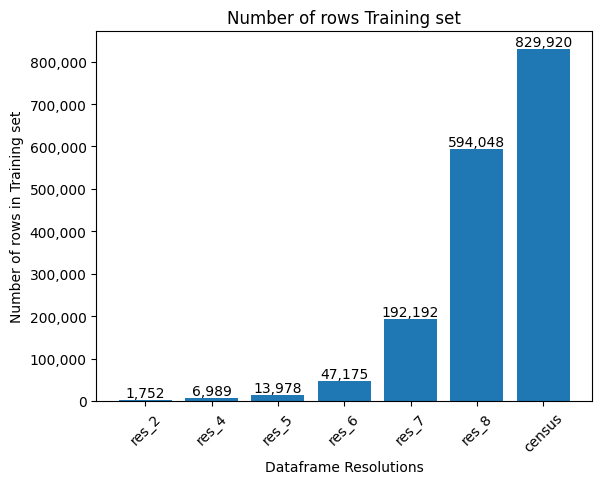

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define the file names and labels for resolutions 1 to 9 plus 'census'
file_names = ['2_res_test', '4_res_test', '5_res_test', '6_res_test', '7_res_test', '8_res_test', '0_res_test']
labels = [f'res_{name.split("_")[0]}' for name in file_names[:-1]] + ['census']

# Read the CSV files and get the lengths
lengths = [len(pd.read_csv(f'./data/model_input/{name}.csv')) for name in file_names]

# Plot the bar graph
bars = plt.bar(labels, lengths)
plt.xlabel('Dataframe Resolutions')
plt.ylabel('Number of rows in Training set')
plt.title('Number of rows Training set')
plt.xticks(rotation=45)

# Format y-axis with commas
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Annotate the bars for df_3, df_4, df_5, and df_6 (you can change the range if you want specific annotations)
for i, bar in enumerate(bars[:10]):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', ha='center', va='bottom')

plt.show()

## Find Architectures
We will explore three distinct Architectures, tailored for low, medium, and high-resolution Dataframes. The increase in data with higher resolutions necessitates a more complex architecture. As referenced by Zhang et al. (https://arxiv.org/pdf/1611.03530.pdf), a basic two-layer ReLU network with p = 2n+d parameters can label any sample of size n in d dimensions. This insight will guide our approach. The grouped resolutions are:

* Resolutions 2-5: Training data ranging from 1752 to 13,978
* Resolutions 6 & 7: Data range of 47,175 to 192,192.
* Resolutions 8 & census tracts: 594,048 to 829,920.

Parameters regarding formula, roughly:
* Resolutions 2-5: **~15k parameters**
* Resolutions 6 & 7: **~120k parameters**
* Resolutions 8,9 & census tracts: **~1,4m parameters** --> takes too much training time, hence we only a smaller network!


In the following we will try to find a suitable architecture for each group. We will evaluate the architecture on the smallest resolution of each group with horizon 1.

### Resolution Group One: Resolution 2-5

Let's first create an architecture for the smallest resolution group. We use a dropout layer, where a 10% dropout layer is added in an early layer. This makes the model more robust to noisy data and prevents overfitting.

In [36]:
RESOLUTION = 2
HORIZON = 1

df_train, df_test = get_df_by_resolution(RESOLUTION)
df_train, df_val = get_validation_set(df_train, df_test, val_ratio=0.1)
X_train, y_train = get_X_y(df_train, HORIZON)
X_val, y_val = get_X_y(df_val, HORIZON)
X_test, y_test = get_X_y(df_test, HORIZON)
X_train_scaled, X_val_scaled, X_test_scaled = scale_data(X_train, X_val, X_test)


In [37]:
def get_model_group_one(X_train):
  model = Sequential()
  model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # 64 units in first hidden layer
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1))
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])
  return model

model = get_model_group_one(X_train)
model.count_params()


15009

In [38]:
history = model.fit(X_train_scaled, y_train, epochs=128, batch_size=64, validation_data=(X_val_scaled, y_val))

Epoch 1/128
11/11 [==============================] - 1s 30ms/step - loss: 7836994.0000 - mean_absolute_error: 2430.7368 - val_loss: 7698065.5000 - val_mean_absolute_error: 2412.1462
Epoch 2/128
11/11 [==============================] - 0s 15ms/step - loss: 7834255.0000 - mean_absolute_error: 2430.1587 - val_loss: 7693194.0000 - val_mean_absolute_error: 2411.1040
Epoch 3/128
11/11 [==============================] - 0s 15ms/step - loss: 7823753.0000 - mean_absolute_error: 2427.9985 - val_loss: 7672276.0000 - val_mean_absolute_error: 2406.8101
Epoch 4/128
11/11 [==============================] - 0s 14ms/step - loss: 7781745.5000 - mean_absolute_error: 2419.7424 - val_loss: 7591185.0000 - val_mean_absolute_error: 2391.0598
Epoch 5/128
11/11 [==============================] - 0s 14ms/step - loss: 7625584.0000 - mean_absolute_error: 2390.0186 - val_loss: 7293578.5000 - val_mean_absolute_error: 2335.5955
Epoch 6/128
11/11 [==============================] - 0s 14ms/step - loss: 7073510.5000 - m

In the plots below, we can see that the validation error barely changes after 64 epochs. Hence we will set the epochs to 64 for this resolution class.

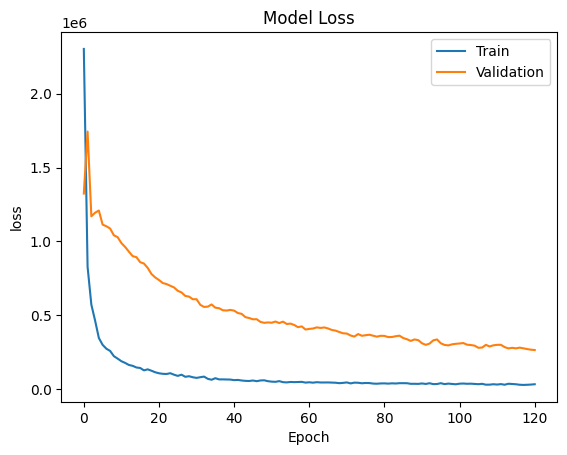

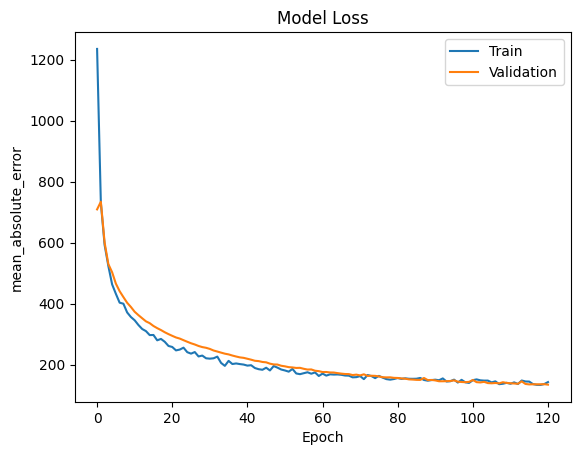

In [44]:
plot_loss(history, leave_first_n_out=7)
plot_loss(history, error='mean_absolute_error', leave_first_n_out=7)
GROUP_ONE_EPOCH = 64

### Resolution Group two: Resolutions 6 & 7
This architecture is very similar to the first layer, however it contains significantly more layers, as we work with more data.

In [21]:
RESOLUTION = 6
HORIZON = 1

df_train, df_test = get_df_by_resolution(RESOLUTION)
df_train, df_val = get_validation_set(df_train, df_test, val_ratio=0.1)
X_train, y_train = get_X_y(df_train, HORIZON)
X_val, y_val = get_X_y(df_val, HORIZON)
X_train_scaled, X_val_scaled = scale_data(X_train, X_val)


In [30]:
def get_model_group_two(X_train):
  model = Sequential()
  model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # 64 units in first hidden layer
  model.add(Dropout(0.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1))
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])
  return model

model = get_model_group_two(X_train)
model.count_params()

152353

In [31]:
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_data=(X_val_scaled, y_val))

Epoch 1/50
295/295 [==============================] - 5s 17ms/step - loss: 20682.5410 - mean_absolute_error: 38.7932 - val_loss: 5434.7368 - val_mean_absolute_error: 22.3488
Epoch 2/50
295/295 [==============================] - 5s 16ms/step - loss: 3536.1458 - mean_absolute_error: 18.5269 - val_loss: 1938.4552 - val_mean_absolute_error: 13.8054
Epoch 3/50
295/295 [==============================] - 5s 16ms/step - loss: 2644.3760 - mean_absolute_error: 16.0782 - val_loss: 1214.6538 - val_mean_absolute_error: 11.6249
Epoch 4/50
295/295 [==============================] - 5s 16ms/step - loss: 2844.7344 - mean_absolute_error: 15.2149 - val_loss: 961.9982 - val_mean_absolute_error: 10.3578
Epoch 5/50
295/295 [==============================] - 5s 16ms/step - loss: 2260.1897 - mean_absolute_error: 13.7468 - val_loss: 880.9815 - val_mean_absolute_error: 9.6952
Epoch 6/50
295/295 [==============================] - 5s 16ms/step - loss: 1454.3044 - mean_absolute_error: 12.0635 - val_loss: 2756.9919

In the plots below, we can see that the validation error barely changes after 32 epochs. Hence we will set the epochs to 32 for this resolution class.

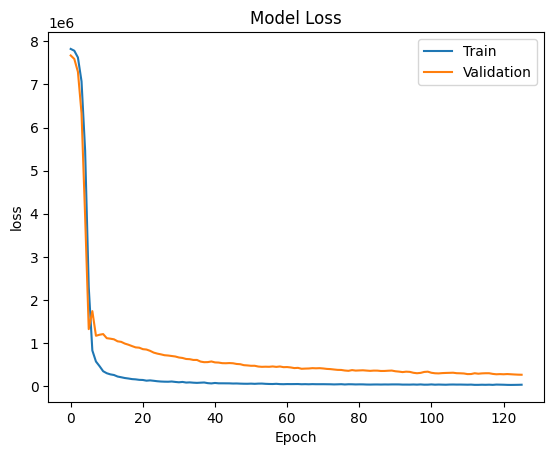

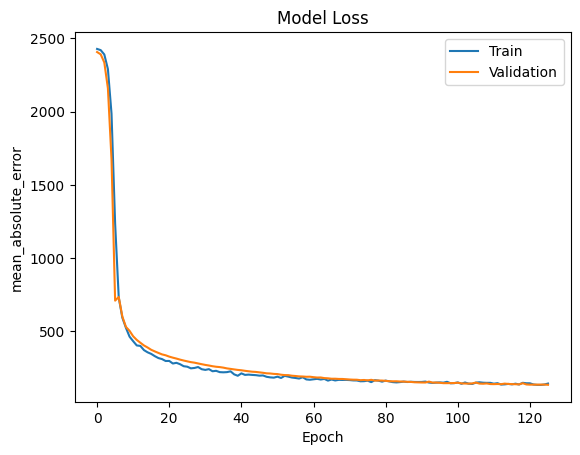

In [46]:
plot_loss(history, leave_first_n_out=2)
plot_loss(history, error='mean_absolute_error', leave_first_n_out=2)
GROUP_Two_EPOCH = 32

### Resolution Group Three: 8 & Census Tract
This architecture is also very similar to the first layer, however it contains significantly more layers, as we work with more data.

In [52]:
RESOLUTION = 8
HORIZON = 1

df_train, df_test = get_df_by_resolution(RESOLUTION)
df_train, df_val = get_validation_set(df_train, df_test, val_ratio=0.1)
X_train, y_train = get_X_y(df_train, HORIZON)
X_val, y_val = get_X_y(df_val, HORIZON)
X_train_scaled, X_val_scaled = scale_data(X_train, X_val)

In [54]:
def get_model_group_three(X_train):
  model = Sequential()
  model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # 64 units in first hidden layer
  model.add(Dropout(0.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1))
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])
  return model

model = get_model_group_three(X_train)

In [55]:
history = model.fit(X_train_scaled, y_train, epochs=32, batch_size=64, validation_data=(X_val_scaled, y_val))
GROUP_THREE_EPOCH = 20

Epoch 1/32
3713/3713 [==============================] - 63s 17ms/step - loss: 93.9260 - mean_absolute_error: 1.9192 - val_loss: 11.9041 - val_mean_absolute_error: 0.9670
Epoch 2/32
3713/3713 [==============================] - 61s 16ms/step - loss: 48.2214 - mean_absolute_error: 1.2404 - val_loss: 38.2233 - val_mean_absolute_error: 1.0808
Epoch 3/32
3713/3713 [==============================] - 60s 16ms/step - loss: 31.0869 - mean_absolute_error: 0.9558 - val_loss: 22.4319 - val_mean_absolute_error: 1.5313
Epoch 4/32
3713/3713 [==============================] - 61s 16ms/step - loss: 30.0270 - mean_absolute_error: 0.9136 - val_loss: 3.9435 - val_mean_absolute_error: 0.4886
Epoch 5/32
3713/3713 [==============================] - 60s 16ms/step - loss: 27.9642 - mean_absolute_error: 0.8468 - val_loss: 5.0451 - val_mean_absolute_error: 0.6312
Epoch 6/32
3713/3713 [==============================] - 62s 17ms/step - loss: 13.2203 - mean_absolute_error: 0.6858 - val_loss: 16.4005 - val_mean_absol

Here we can see that the validation does not steadily decrease, however the we can still see that at around 24 Epochs, the loss for both validation and test seems to become a bit more steady.

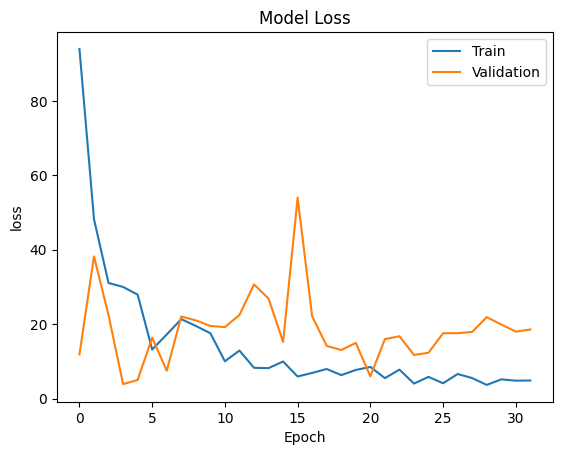

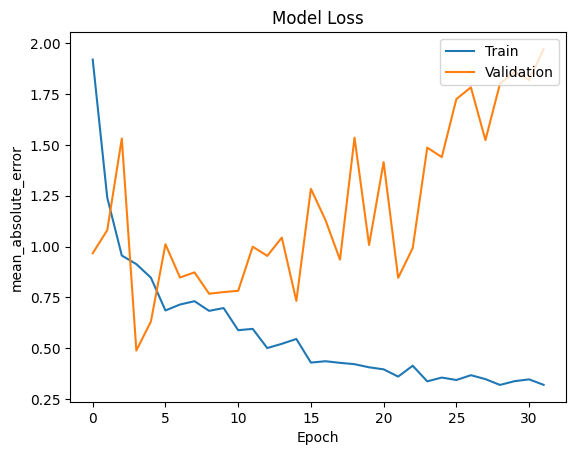

In [58]:
plot_loss(history, leave_first_n_out=0)
plot_loss(history, error='mean_absolute_error', leave_first_n_out=0)
GROUP_THREE_EPOCH = 24

## Build Final Models
In this section we leverage the insights we previously obtained and train the models sequentially.

In [61]:
RESOLUTIONS = [2, 4, 5, 6, 7, 8, 0]
TARGETS = ['demand_target_bucket_1', 'demand_target_bucket_2', 'demand_target_bucket_6', 'demand_target_bucket_24']
HORIZONS = [1,2,6,24]

GROUP_ONE = [2,3,5]
GROUP_TWO = [6,7]
GROUP_THREE = [8,0]

In [ ]:
GROUP_ONE_EPOCH = 64
GROUP_TWO_EPOCH = 32
GROUP_THREE_EPOCH = 24
results = []
for resolution in RESOLUTIONS:
  for horizon in HORIZONS:
    # Get dataframes for resolution
    df_train, df_test = get_df_by_resolution(resolution)
    # Get X and y's
    X_train, y_train = get_X_y(df_train, horizon)
    X_test, y_test = get_X_y(df_test, horizon)
    X_train_scaled, _, X_test_scaled = scale_data(X_train, X_train, X_test)
    y_test.mean()


    # Check if a trained model is already available
    model_path = f'./data/NN_checkpoints/{resolution}_res_{horizon}_target.h5'
    if os.path.exists(model_path):
      print(f"Loading model from {model_path}...")
      model = load_model(model_path)
      print("Model loaded successfully.")
    else:

      if resolution in GROUP_ONE:
        print('ONE!')
        model = get_model_group_one(X_train)
        num_epochs = GROUP_ONE_EPOCH
      elif resolution in GROUP_TWO:
        print('TWO!')
        model = get_model_group_two(X_train)
        num_epochs = GROUP_TWO_EPOCH
      else:
        print('THREE!')
        model = get_model_group_three(X_train)
        num_epochs = GROUP_THREE_EPOCH

      history = model.fit(X_train_scaled, y_train, epochs=num_epochs, batch_size=64)

      model.save(model_path)


    y_pred = model.predict(X_test_scaled)
    y_pred = y_pred.reshape(-1)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append([resolution, horizon, mse, mae, r2, y_test.mean()])
    pd.DataFrame(results,columns=['resolution', 'horizon', 'mse', 'mae', 'r2', 'test_mean']).to_csv(f'./data/results/NN_results.csv')


df_results = pd.DataFrame(results,columns=['resolution', 'horizon', 'mse', 'mae', 'r2', 'test_mean'])

THREE!
Epoch 1/24
37128/37128 [==============================] - 70s 2ms/step - loss: 25.4053 - mean_absolute_error: 0.8491
Epoch 2/24
37128/37128 [==============================] - 69s 2ms/step - loss: 6.0482 - mean_absolute_error: 0.4719
Epoch 3/24
37128/37128 [==============================] - 69s 2ms/step - loss: 3.6182 - mean_absolute_error: 0.3494
Epoch 4/24
37128/37128 [==============================] - 69s 2ms/step - loss: 2.8236 - mean_absolute_error: 0.2560
Epoch 5/24
37128/37128 [==============================] - 69s 2ms/step - loss: 1.6601 - mean_absolute_error: 0.2033
Epoch 6/24
37128/37128 [==============================] - 69s 2ms/step - loss: 1.4792 - mean_absolute_error: 0.1765
Epoch 7/24
37128/37128 [==============================] - 69s 2ms/step - loss: 1.2115 - mean_absolute_error: 0.1520
Epoch 8/24
37128/37128 [==============================] - 69s 2ms/step - loss: 0.8495 - mean_absolute_error: 0.1320
Epoch 9/24
37128/37128 [==============================] - 68s 2m